In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Pablo\AppData\Local\Temp\ipykernel_25308\822149826.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

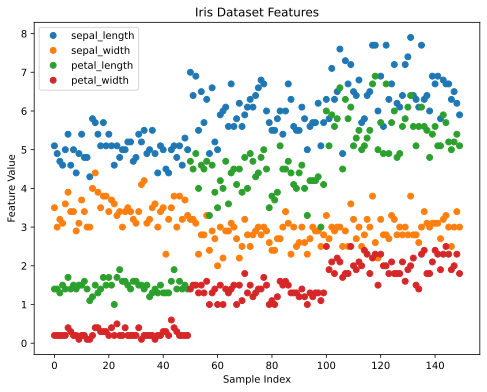

In [4]:
iris.plot(marker='o', linestyle='', figsize=(8, 6))
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.title("Iris Dataset Features")
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)

def get_batch_loaders(train_dataset, batch_size=16):
    # drop_last=True is used to drop the last batch if it's smaller than the specified batch size,
    # which can help maintain consistent batch sizes during training.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

In [6]:
def create_model(learning_rate=0.0005):
    model = nn.Sequential(
        nn.Linear(4, 64), #input layer
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3) # output layer with 3 classes
    )

    # loss function for multi-class classification
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_fn, optimizer

def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs):
    train_accuracies = []
    test_accuracies = []
    losses = []

    for epoch in range(epochs):
        batch_accuracies = []
        batch_losses = []
        model.train()
        for X_batch, y_batch in train_loader:
            
            y_pred_logits = model(X_batch)
            loss = loss_fn(y_pred_logits, y_batch)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc = (torch.argmax(y_pred_logits, dim=1) == y_batch).float().mean()
            batch_accuracies.append(batch_acc.item())
            batch_losses.append(loss.item())
        
        train_accuracies.append(np.mean(batch_accuracies))
        losses.append(np.mean(batch_losses))

        # Evaluate on test data
        model.eval()
        with torch.no_grad(): # we don't need gradients for evaluation, which saves memory and computations
            y_pred_logits_test = model(test_loader.dataset.tensors[0])
            y_pred_test = torch.argmax(y_pred_logits_test, dim=1)
            test_acc = (y_pred_test == test_loader.dataset.tensors[1]).float().mean().item()
            test_accuracies.append(test_acc)

    return train_accuracies, test_accuracies, losses

In [10]:
batch_sizes = [2**i for i in range(1, 7)]
learning_rate = 0.001
num_epochs = 500

train_acc_results = np.zeros((num_epochs, len(batch_sizes)))
test_acc_results = np.zeros((num_epochs, len(batch_sizes)))

for i, bs in enumerate(batch_sizes):
    train_loader = get_batch_loaders(train_dataset, batch_size=bs)
    model, loss_fn, optimizer = create_model(learning_rate=learning_rate)
    train_acc, test_acc, losses = train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs=num_epochs)

    train_acc_results[:, i] = train_acc
    test_acc_results[:, i] = test_acc

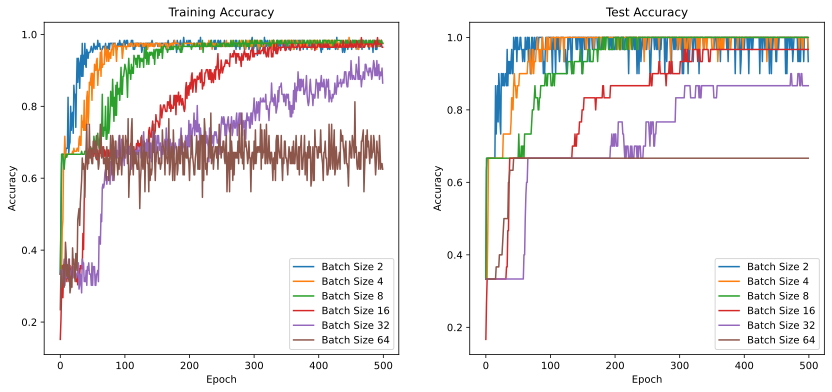

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i, bs in enumerate(batch_sizes):
    ax[0].plot(train_acc_results[:, i], label=f'Batch Size {bs}')
    ax[1].plot(test_acc_results[:, i], label=f'Batch Size {bs}')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Accuracy')
ax[1].legend()

plt.show()

# smaller batch sizes in this case make the model to learn faster. also the more heterogeneous the batch is, 
# the better the model learns. in this case, smaller batch sizes are more heterogeneous, which can lead to 
# better generalization and faster convergence.